In [18]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import CubicSpline
import bernstein_coeff_order10_arbitinterval
from scipy.linalg import block_diag
import time

import jax.numpy as jnp
from jax import jit, jacfwd, jacrev, random, vmap, grad
import time
from jax.config import config
config.update("jax_enable_x64", True)

In [11]:
def bernstein_coeff_order10_new(n, tmin, tmax, t_actual):
    l = tmax - tmin
    t = (t_actual - tmin) / l

    P0 = scipy.special.binom(n, 0) * ((1 - t) ** (n - 0)) * t ** 0
    P1 = scipy.special.binom(n, 1) * ((1 - t) ** (n - 1)) * t ** 1
    P2 = scipy.special.binom(n, 2) * ((1 - t) ** (n - 2)) * t ** 2
    P3 = scipy.special.binom(n, 3) * ((1 - t) ** (n - 3)) * t ** 3
    P4 = scipy.special.binom(n, 4) * ((1 - t) ** (n - 4)) * t ** 4
    P5 = scipy.special.binom(n, 5) * ((1 - t) ** (n - 5)) * t ** 5
    P6 = scipy.special.binom(n, 6) * ((1 - t) ** (n - 6)) * t ** 6
    P7 = scipy.special.binom(n, 7) * ((1 - t) ** (n - 7)) * t ** 7
    P8 = scipy.special.binom(n, 8) * ((1 - t) ** (n - 8)) * t ** 8
    P9 = scipy.special.binom(n, 9) * ((1 - t) ** (n - 9)) * t ** 9
    P10 = scipy.special.binom(n, 10) * ((1 - t) ** (n - 10)) * t ** 10

    P0dot = -10.0 * (-t + 1) ** 9
    P1dot = -90.0 * t * (-t + 1) ** 8 + 10.0 * (-t + 1) ** 9
    P2dot = -360.0 * t ** 2 * (-t + 1) ** 7 + 90.0 * t * (-t + 1) ** 8
    P3dot = -840.0 * t ** 3 * (-t + 1) ** 6 + 360.0 * t ** 2 * (-t + 1) ** 7
    P4dot = -1260.0 * t ** 4 * (-t + 1) ** 5 + 840.0 * t ** 3 * (-t + 1) ** 6
    P5dot = -1260.0 * t ** 5 * (-t + 1) ** 4 + 1260.0 * t ** 4 * (-t + 1) ** 5
    P6dot = -840.0 * t ** 6 * (-t + 1) ** 3 + 1260.0 * t ** 5 * (-t + 1) ** 4
    P7dot = -360.0 * t ** 7 * (-t + 1) ** 2 + 840.0 * t ** 6 * (-t + 1) ** 3
    P8dot = 45.0 * t ** 8 * (2 * t - 2) + 360.0 * t ** 7 * (-t + 1) ** 2
    P9dot = -10.0 * t ** 9 + 9 * t ** 8 * (-10.0 * t + 10.0)
    P10dot = 10.0 * t ** 9

    P0ddot = 90.0 * (-t + 1) ** 8
    P1ddot = 720.0 * t * (-t + 1) ** 7 - 180.0 * (-t + 1) ** 8
    P2ddot = 2520.0 * t ** 2 * (-t + 1) ** 6 - 1440.0 * t * (-t + 1) ** 7 + 90.0 * (-t + 1) ** 8
    P3ddot = 5040.0 * t ** 3 * (-t + 1) ** 5 - 5040.0 * t ** 2 * (-t + 1) ** 6 + 720.0 * t * (-t + 1) ** 7
    P4ddot = 6300.0 * t ** 4 * (-t + 1) ** 4 - 10080.0 * t ** 3 * (-t + 1) ** 5 + 2520.0 * t ** 2 * (-t + 1) ** 6
    P5ddot = 5040.0 * t ** 5 * (-t + 1) ** 3 - 12600.0 * t ** 4 * (-t + 1) ** 4 + 5040.0 * t ** 3 * (-t + 1) ** 5
    P6ddot = 2520.0 * t ** 6 * (-t + 1) ** 2 - 10080.0 * t ** 5 * (-t + 1) ** 3 + 6300.0 * t ** 4 * (-t + 1) ** 4
    P7ddot = -360.0 * t ** 7 * (2 * t - 2) - 5040.0 * t ** 6 * (-t + 1) ** 2 + 5040.0 * t ** 5 * (-t + 1) ** 3
    P8ddot = 90.0 * t ** 8 + 720.0 * t ** 7 * (2 * t - 2) + 2520.0 * t ** 6 * (-t + 1) ** 2
    P9ddot = -180.0 * t ** 8 + 72 * t ** 7 * (-10.0 * t + 10.0)
    P10ddot = 90.0 * t ** 8

    P = np.hstack((P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10))
    Pdot = np.hstack((P0dot, P1dot, P2dot, P3dot, P4dot, P5dot, P6dot, P7dot, P8dot, P9dot, P10dot)) / l
    Pddot = np.hstack((P0ddot, P1ddot, P2ddot, P3ddot, P4ddot, P5ddot, P6ddot, P7ddot, P8ddot, P9ddot, P10ddot)) / (l ** 2)
    return P, Pdot, Pddot

In [12]:
class OptimizerLane():

    def __init__(self):
        self.rho_eq = 1.0
        self.rho_goal = 1.0
        self.rho_lane = 1.0
        self.rho_nonhol = 1.0
        self.rho_w_psi = 1.0
        self.rho_psi = 1.0
        self.maxiter = 500
        self.weight_smoothness = 1.0
        self.weight_smoothness_psi = 1.0

        self.t_fin = 8.0
        self.num = 100
        self.t = self.t_fin/self.num

        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        self.A_eq_psi = np.vstack((  self.P[0], self.Pdot[0], self.P[-1], self.Pdot[-1]         ))
        
        self.cost_smoothness = self.weight_smoothness*np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_v = self.weight_smoothness*np.dot(self.Pddot.T, self.Pddot)
        
        self.cost_smoothness_psi = self.weight_smoothness_psi*np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)
        
        
        self.rho_mid = 0.01
        self.mid_idx = np.array([ int(self.num/4), int(self.num/2), int(3*self.num/4)  ])        
        
        self.P_jax = jnp.asarray(self.P)
        self.Pdot_jax = jnp.asarray(self.Pdot)
        self.Pddot_jax = jnp.asarray(self.Pddot)

        # self.lamda_wc = np.zeros(self.nvar)
        # self.lamda_ws = np.zeros(self.nvar)

        # self.lamda_psi = np.zeros(self.nvar)
        # self.lamda_v = np.zeros(self.nvar)
        # self.cost_smoothness = block_diag(self.weight_smoothness*np.dot(self.Pddot.T, self.Pddot), 0.01*np.dot(self.Pddot.T, self.Pddot) )
        ######################################################################### Converting to Jax for objective and gradient computation


    def compute_w_psi(self, x_init, y_init, x_fin, y_fin, x_mid, y_mid, psi, v, lamda_wc, lamda_ws):
        A_w = self.P
        A_w_psi = self.P
        b_wc_psi = np.cos(psi)
        b_ws_psi = np.sin(psi)
        
        temp_x = np.cumsum(self.P*(v*self.t)[:, np.newaxis] , axis = 0)
        temp_y = np.cumsum(self.P*(v*self.t)[:, np.newaxis] , axis = 0)
        
        
        
        
        A_x = temp_x[0:self.num-1] ########## \sum_t (x-x_t)^2  = \Vert A_x[-1] c_w_c_psi -x_t\Vert_2^2
        A_y = temp_y[0:self.num-1]

        A_x_goal = A_x[-1].reshape(1, self.nvar)
        b_x_goal = np.array([x_fin-x_init])

        A_y_goal = A_y[-1].reshape(1, self.nvar)
        b_y_goal = np.array([y_fin-y_init])

        A_x_mid = A_x[self.mid_idx]
        A_y_mid = A_y[self.mid_idx]

        b_x_mid = x_mid-x_init
        b_y_mid = y_mid-y_init

        obj_x_goal = self.rho_goal*np.dot(A_x_goal.T, A_x_goal)
        linterm_augment_x_goal = -self.rho_goal*np.dot(A_x_goal.T, b_x_goal)

        obj_y_goal = self.rho_goal*np.dot(A_y_goal.T, A_y_goal)
        linterm_augment_y_goal = -self.rho_goal*np.dot(A_y_goal.T, b_y_goal)

        obj_x_mid = self.rho_mid*np.dot(A_x_mid.T, A_x_mid)
        linterm_augment_x_mid = -self.rho_mid*np.dot(A_x_mid.T, b_x_mid)

        obj_y_mid = self.rho_mid*np.dot(A_y_mid.T, A_y_mid)
        linterm_augment_y_mid = -self.rho_mid*np.dot(A_y_mid.T, b_y_mid)

        obj_wc_psi = self.rho_w_psi*np.dot(A_w_psi.T, A_w_psi)
        linterm_augment_wc_psi = -self.rho_w_psi*np.dot(A_w_psi.T, b_wc_psi)
        
        obj_ws_psi = self.rho_w_psi*np.dot(A_w_psi.T, A_w_psi)
        linterm_augment_ws_psi = -self.rho_w_psi*np.dot(A_w_psi.T, b_ws_psi)

        cost_wc = obj_wc_psi+obj_x_goal+obj_x_mid
        lincost_wc = -lamda_wc+linterm_augment_x_goal+linterm_augment_wc_psi+linterm_augment_x_mid

        cost_ws = obj_y_goal+obj_ws_psi+obj_y_mid
        lincost_ws = -lamda_ws+linterm_augment_y_goal+linterm_augment_ws_psi+linterm_augment_y_mid

        c_wc_psi = np.linalg.solve(-cost_wc, lincost_wc)
        c_ws_psi = np.linalg.solve(-cost_ws, lincost_ws)

        wc = np.dot(self.P, c_wc_psi)
        ws = np.dot(self.P, c_ws_psi)

        return wc, ws, c_wc_psi, c_ws_psi


    def compute_psi(self, wc, ws, b_eq_psi, lamda_psi):

        A_psi = self.P
        b_psi = np.arctan2(ws, wc)

        obj_psi = self.rho_psi*np.dot(A_psi.T, A_psi)
        linterm_augment_psi = -self.rho_psi*np.dot(A_psi.T, b_psi)

        cost_psi = self.cost_smoothness_psi+obj_psi+self.rho_eq*np.dot(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -lamda_psi+linterm_augment_psi-self.rho_eq*np.dot(self.A_eq_psi.T, b_eq_psi)

        sol = np.linalg.solve(-cost_psi, lincost_psi)

        c_psi = sol[0:self.nvar]

        psi = np.dot(self.P, c_psi)
        # self.psidot = np.dot(self.Pdot, c_psi)
        # self.psiddot = np.dot(self.Pddot, c_psi)


        res_psi = np.dot(A_psi, c_psi)-b_psi
        res_eq_psi = np.dot(self.A_eq_psi, c_psi)-b_eq_psi
        lamda_psi = lamda_psi-self.rho_psi*np.dot(A_psi.T, res_psi)-self.rho_eq*np.dot(self.A_eq_psi.T, res_eq_psi)


        # self.lamda_psi = self.lamda_psi+0.90*(self.lamda_psi-lamda_psi_old)

        return psi, c_psi, np.linalg.norm(res_psi), np.linalg.norm(res_eq_psi), lamda_psi

    def compute_v(self, v_init, x_init, x_fin, x_mid, y_mid, psi, lamda_v):

        temp_x = np.cumsum(self.P*(np.cos(psi)*self.t)[:, np.newaxis], axis = 0)
        temp_y = np.cumsum(self.P*(np.sin(psi)*self.t)[:, np.newaxis], axis = 0)

        A_x = temp_x[0:self.num-1]
        A_y = temp_y[0:self.num-1]

        A_x_goal = A_x[-1].reshape(1, self.nvar)
        b_x_goal = np.array([x_fin-x_init ])

        A_y_goal = A_y[-1].reshape(1, self.nvar)
        b_y_goal = np.array([y_fin-y_init ])

        A_x_mid = A_x[self.mid_idx]
        A_y_mid = A_y[self.mid_idx]

        b_x_mid = x_mid-x_init
        b_y_mid = y_mid-y_init

        A_vel_init = self.P[0].reshape(1, self.nvar)
        b_vel_init = np.array([v_init])

        obj_x_goal = self.rho_goal*np.dot(A_x_goal.T, A_x_goal)
        linterm_augment_x_goal = -self.rho_goal*np.dot(A_x_goal.T, b_x_goal)

        obj_y_goal = self.rho_goal*np.dot(A_y_goal.T, A_y_goal)
        linterm_augment_y_goal = -self.rho_goal*np.dot(A_y_goal.T, b_y_goal)

        obj_x_mid = self.rho_mid*np.dot(A_x_mid.T, A_x_mid)
        linterm_augment_x_mid = -self.rho_mid*np.dot(A_x_mid.T, b_x_mid)

        obj_y_mid = self.rho_mid*np.dot(A_y_mid.T, A_y_mid)
        linterm_augment_y_mid = -self.rho_mid*np.dot(A_y_mid.T, b_y_mid)

        obj_v_init = self.rho_eq*np.dot(A_vel_init.T, A_vel_init)
        linterm_augment_v_init = -self.rho_eq*np.dot(A_vel_init.T, b_vel_init)

        cost = obj_x_goal+obj_y_goal+self.cost_smoothness_v+obj_x_mid+obj_y_mid+obj_v_init
        lincost = -lamda_v+linterm_augment_x_goal+linterm_augment_y_goal+linterm_augment_x_mid+linterm_augment_y_mid+linterm_augment_v_init

        sol = np.linalg.solve(-cost, lincost)

        # cv = hstack((cv_1, cv_2, sol, cv_10, cv_11))

        v = np.dot(self.P, sol)
        # self.vdot = np.dot(self.Pdot, sol)


        res_v_init = np.dot(A_vel_init, sol)-b_vel_init
        lamda_v = lamda_v-self.rho_eq*np.dot(A_vel_init.T, res_v_init)

        return sol, lamda_v, v



    def solve(self, x_init, y_init, x_fin, y_fin, v_init, v_fin, psi_init, psidot_init, psi_fin, psidot_fin, x_mid, y_mid):
        v = v_init*np.ones(self.num)
        psi = psi_init*np.ones(self.num)


        res_psi = np.ones(self.maxiter)
        res_w_psi = np.ones(self.maxiter)
        res_w = np.ones(self.maxiter)
        res_eq_psi = np.ones(self.maxiter)
        res_eq = np.ones(self.maxiter)

        lamda_wc = np.zeros(self.nvar)
        lamda_ws = np.zeros(self.nvar)
        lamda_psi = np.zeros(self.nvar)
        lamda_v = np.zeros(self.nvar)

        b_eq_psi = np.hstack((  psi_init, psidot_init, psi_fin, psidot_fin        ))


        for i in range(0, self.maxiter):	


            wc, ws, c_wc_psi, c_ws_psi = self.compute_w_psi(x_init, y_init, x_fin, y_fin, x_mid, y_mid, psi, v, lamda_wc, lamda_ws)
            psi, c_psi, res_psi[i], res_eq_psi[i], lamda_psi = self.compute_psi(wc, ws, b_eq_psi, lamda_psi)
            c_v, lamda_v, v = self.compute_v(v_init, x_init, x_fin, x_mid, y_mid, psi, lamda_v)



            res_wc = wc-np.cos(psi)
            res_ws = ws-np.sin(psi)
            self.A_w = self.P

            # lamda_wc_old = self.lamda_wc
            # lamda_ws_old = self.lamda_ws


            lamda_wc = lamda_wc-self.rho_w_psi*np.dot(self.A_w.T, res_wc)
            lamda_ws = lamda_ws-self.rho_w_psi*np.dot(self.A_w.T, res_ws)

            # self.lamda_wc = self.lamda_wc+0.90*(self.lamda_wc-lamda_wc_old)
            # self.lamda_ws = self.lamda_ws+0.90*(self.lamda_ws-lamda_ws_old)


            res_w[i] = np.linalg.norm( np.hstack(( res_wc, res_ws ))  )
            # res_eq[i] = np.linalg.norm( np.hstack((  res_eq_x_vec, res_eq_y_vec     ))  )
            # res_obs_lane[i] = np.linalg.norm( np.hstack(( res_x_obs_vec_lane, res_y_obs_vec_lane         ))  )


        primal_sol = np.hstack(( c_psi, c_v         ))
        dual_sol = np.hstack((  lamda_wc, lamda_ws, lamda_psi, lamda_v       ))

        return primal_sol, dual_sol, res_eq_psi, res_w, c_v

In [19]:
def objective(P_jax, Pdot_jax, nvar, mid_idx, t, rho_params, boundary_init, variable_params, primal_sol):
    rho_goal = rho_params[0]
    rho_eq = rho_params[1]
    rho_mid = rho_params[2]



    x_init = boundary_init[0]
    y_init = boundary_init[1]
    v_init = boundary_init[2]
    psi_init = boundary_init[3]
    psidot_init = boundary_init[4]

    # variable_params = jnp.hstack(( x_fin, y_fin, psi_fin, psidot_fin, x_mid, y_mid       ))

    x_fin = variable_params[0]
    y_fin = variable_params[1]
    psi_fin = variable_params[2]
    psidot_fin = variable_params[3]
    x_mid = variable_params[4:7]
    y_mid = variable_params[7:10]


    # c_wc_psi_jax = primal_sol_jax[0:nvar]
    # c_ws_psi_jax = primal_sol[nvar:2*nvar]

    c_psi_jax = primal_sol[0:nvar]
    c_v_jax = primal_sol[nvar:2*nvar]

    v_jax = jnp.dot(P_jax, c_v_jax)
    psi_jax = jnp.dot(P_jax, c_psi_jax)
    psidot_jax = jnp.dot(Pdot_jax, c_psi_jax)

    x_temp = x_init+jnp.cumsum(v_jax*jnp.cos(psi_jax)*t)
    y_temp = y_init+jnp.cumsum(v_jax*jnp.sin(psi_jax)*t)

    x = jnp.hstack(( x_init, x_temp[0:-1]    ))
    y = jnp.hstack(( y_init, y_temp[0:-1]    ))

    cost_final_pos = 0.5*rho_goal*((x[-1]-x_fin)**2+(y[-1]-y_fin)**2)
    cost_psi_term = 0.5*rho_eq*( ( psi_jax[0]-psi_init)**2+( psidot_jax[0]-psidot_init)**2+( psi_jax[-1]-psi_fin)**2+( psidot_jax[-1]-psidot_fin)**2 )
    cost_v_term = 0.5*rho_eq*(v_jax[0]-v_init)**2
    cost_mid_term = 0.5*rho_mid*( jnp.sum(( x[mid_idx]-x_mid  )**2)+jnp.sum(( y[mid_idx]-y_mid  )**2) )

    cost = cost_final_pos+cost_psi_term+cost_v_term+cost_mid_term

    return cost

In [20]:
prob = OptimizerLane()


x_init = 129
y_init = 202.3-2.0

x_fin = 199
y_fin = 193.0

x_fin = 238
y_fin = 139.0-6.0

# x_init = 0.0
# y_init = 0.0

# x_fin = 40
# y_fin = 30.0


v_init = 20.0
v_fin =  16.0


vdot_init = 0.0
vdot_fin = 0.0

psi_init = 0.0
psidot_init = 0.0
psiddot_init = 0.0


psi_fin = -91*np.pi/180
psidot_fin = 0.0
psiddot_fin = 0.0

x_mid = np.hstack(( 162, 198, 228))
y_mid = np.hstack(( 202, 193, 170))

# x_lane_left, y_lane_left, x_lane_right, y_lane_right, x_lane_center, y_lane_center = prob.extract_lane_boundary(x_init, y_init, x_fin, y_fin, v_init)

start = time.time()
primal_sol, dual_sol, res_eq_psi, res_w, c_v = prob.solve(x_init, y_init, x_fin, y_fin, v_init, v_fin, psi_init, psidot_init, psi_fin, psidot_fin, x_mid, y_mid)
print(time.time()-start)

0.135758638381958


In [21]:
##################################3 Jax part
rho_params = jnp.hstack(( prob.rho_goal, prob.rho_eq, prob.rho_mid         ))

boundary_params = jnp.hstack(( x_init, y_init, x_fin, y_fin, v_init, v_fin, psi_init, psidot_init, psi_fin, psidot_fin ))

boundary_init = jnp.hstack(( x_init, y_init, v_init, psi_init, psidot_init  ))
variable_params = jnp.hstack(( x_fin, y_fin, psi_fin, psidot_fin, x_mid, y_mid       ))


primal_sol_jax = jnp.asarray(primal_sol)
# dual_sol_jax = jnp.asarray(dual_sol)


cost = objective(prob.P_jax, prob.Pdot_jax, prob.nvar, prob.mid_idx, prob.t, rho_params, boundary_init, variable_params, primal_sol_jax)


grad_cost = grad(objective, argnums = (8) )

print(grad_cost(prob.P_jax, prob.Pdot_jax, prob.nvar, prob.mid_idx, prob.t, rho_params, boundary_init, variable_params, primal_sol_jax))

[-0.5104121  -0.40530547 -0.2962408  -0.19959609 -0.15905708 -0.18941608
 -0.28357795 -0.42982764 -0.61277431 -0.79712505 -0.88189448  0.07514352
  0.06374343  0.05085512  0.03528932  0.01964048  0.0047717  -0.00837137
 -0.01876402 -0.02583125 -0.02855636 -0.025254  ]


In [22]:
hess_inp = jacfwd(jacrev(objective, argnums = (8)), argnums = (8)  )
hess_param = jacfwd(jacrev(objective, argnums = (8)), argnums=7)

F_yy = hess_inp(prob.P_jax, prob.Pdot_jax, prob.nvar, prob.mid_idx, prob.t, rho_params, boundary_init, variable_params, primal_sol_jax)

F_xy = hess_param(prob.P_jax, prob.Pdot_jax, prob.nvar, prob.mid_idx, prob.t, rho_params, boundary_init, variable_params, primal_sol_jax)


F_yy_inv = jnp.linalg.inv(F_yy)
dgx = jnp.dot(-F_yy_inv, F_xy)


delt = 4.5
variable_params_new = jnp.hstack(( x_fin+delt, y_fin, psi_fin, psidot_fin, x_mid, y_mid       ))
cur_diff = variable_params_new-variable_params
dgx_prod = jnp.matmul(dgx, cur_diff)
new_sol = primal_sol_jax+dgx_prod
print(dgx_prod)

[-5.05555968e-02 -6.50046752e-02  1.04941331e+00 -4.35926984e+00
  7.84766538e+00 -4.70163585e+00 -9.45941751e-02  8.83523914e-01
 -2.36913349e-01  1.48170693e-01  8.46600964e-02 -1.89528246e-04
  1.52203174e+02 -1.38400180e+03  5.53623901e+03 -1.29635938e+04
  1.91098684e+04 -1.84951822e+04  1.21069930e+04 -5.34942289e+03
  1.51293341e+03 -2.34167353e+02]


In [23]:
# c_wc_psi_jax = new_sol[0:prob.nvar]
# c_ws_psi_jax = new_sol[prob.nvar:2*prob.nvar]
c_psi_jax = new_sol[0:prob.nvar]
c_v_jax = primal_sol[prob.nvar:2*prob.nvar]

v_jax = jnp.dot(prob.P_jax, c_v_jax)
psi_jax = jnp.dot(prob.P_jax, c_psi_jax)
psidot_jax = jnp.dot(prob.Pdot_jax, c_psi_jax)


x_temp_new = x_init+jnp.cumsum(v_jax*jnp.cos(psi_jax)*prob.t)
y_temp_new = y_init+jnp.cumsum(v_jax*jnp.sin(psi_jax)*prob.t)

x_new = jnp.hstack(( x_init, x_temp_new[0:-1]    ))
y_new = jnp.hstack(( y_init, y_temp_new[0:-1]    ))

############################################################33

In [24]:
th = np.linspace(0, 2*np.pi, 100)

In [25]:
################### verification

# c_wc_psi = primal_sol[0:prob.nvar]
# c_ws_psi = primal_sol[prob.nvar:2*prob.nvar]
c_psi = primal_sol[0:prob.nvar]
c_v = primal_sol[prob.nvar:2*prob.nvar]



v = np.dot(prob.P, c_v )
psi = np.dot(prob.P, c_psi)

x_temp = x_init+np.cumsum(v*np.cos(psi)*prob.t)
y_temp = y_init+np.cumsum(v*np.sin(psi)*prob.t)

x = np.hstack(( x_init, x_temp[0:-1]    ))
y = np.hstack(( y_init, y_temp[0:-1]    ))

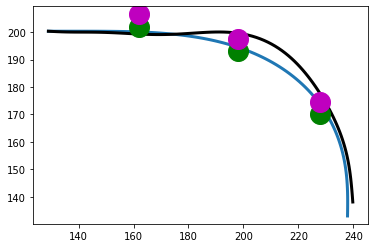

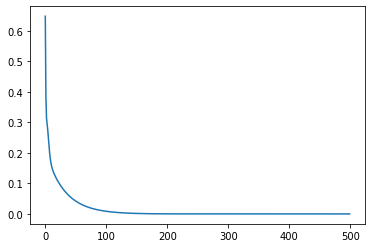

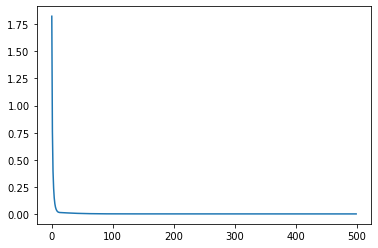

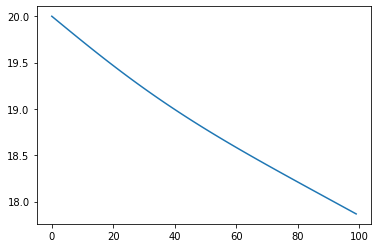

In [26]:
plt.plot(x, y, linewidth = 3.0)
plt.plot(x_new, y_new, '-k', linewidth = 3.0)
plt.plot(x_mid[0], y_mid[0],  'og', markersize = 20.0)
plt.plot(x_mid[1], y_mid[1],  'og', markersize = 20.0)
plt.plot(x_mid[2], y_mid[2],  'og', markersize = 20.0)

plt.plot(x_mid[0], y_mid[0]+delt,  'om', markersize = 20.0)
plt.plot(x_mid[1], y_mid[1]+delt,  'om', markersize = 20.0)
plt.plot(x_mid[2], y_mid[2]+delt,  'om', markersize = 20.0)

plt.axis('equal')
# plt.plot(168*np.ones(1), 196*np.ones(1), 'om', markersize = 40)

# plt.figure(2)
# plt.plot(res_obs)

plt.figure(3)
plt.plot(res_eq_psi)


plt.figure(4)
plt.plot(res_w)

plt.figure(5)
plt.plot(v)


plt.show()